In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc
import sklearn

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [2]:
#
# Define paths to pickle files
# Defining functions
#

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')
ROOT2 = 'pickle_jar/'# ROOT # 

# define lists of temperature
temperature_list = ['292.0', '200.0', '100.0']
c_list = ['Lxy1e1', "Lxy2e1"] #

seed_free_256 = [2928, 82, 1008] # seed for free field case, the order match temperature_list
seed_free_512 = [512292, 512200, 512100] # seed for free field case, the order match temperature_list
seed_cave_256z = [100810,100120] # seed for cavity field case, the order match c_list
seed_cave_512z = [512100110,512100120] # seed for cavity field case, the order match c_list
seed_cave_768z = [768100110,768100120] # seed for cavity field case, the order match c_list
seed_cave_256b = [8100110, 8100120]
seed_cave_512b = [8512110, 8512120]
seed_cave_768b = [8768110, 8768120]

# define patterns of paths that lead to pickle file
freefield_256_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
freefield_512_path = lambda t,s: ROOT2 + "free-{}_512_{}-zero_0_0".format(t,s)
cavityfield_256z_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_512z_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_768z_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_256b_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_512b_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_768b_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_256_path(temp, seed_free_256[i]))
    
for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_512_path(temp, seed_free_512[i]))
    
for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256z_path('100.0', seed_cave_256z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512z_path('100.0', seed_cave_512z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768z_path('100.0', seed_cave_768z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256b_path('100.0', seed_cave_256b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512b_path('100.0', seed_cave_512b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768b_path('100.0', seed_cave_768b[i], c))
    
fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

FREEFIELD_RESULT_256_DICT = { # result in free field path
    temp: freefield_256_path(temp,seed_free_256[i])
    for i, temp in enumerate(temperature_list)
}
FREEFIELD_RESULT_512_DICT = { # result in free field path
    temp: freefield_512_path(temp,seed_free_512[i])
    for i, temp in enumerate(temperature_list)
}
CAVITYFIELD_RESULT_256z_DICT = { # result in cavity field path
    c: cavityfield_256z_path('100.0',seed_cave_256z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512z_DICT = { # result in cavity field path
    c: cavityfield_512z_path('100.0',seed_cave_512z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768z_DICT = { # result in cavity field path
    c: cavityfield_768z_path('100.0',seed_cave_768z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_256b_DICT = { # result in cavity field path
    c: cavityfield_256b_path('100.0',seed_cave_256b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512b_DICT = { # result in cavity field path
    c: cavityfield_512b_path('100.0',seed_cave_512b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768b_DICT = { # result in cavity field path
    c: cavityfield_768b_path('100.0',seed_cave_768b[i], c)
    for i, c in enumerate(c_list)
}

def getall_colliding_time(result_dict_path, limit = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])

    n_pickle = 0
    for i, (j, path) in enumerate(directory_dict.items()):
        if limit and n_pickle >= limit: 
            break

        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue
            
        atoms = result_dict['atoms']
        
        time = get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])

        del result_dict
        n_pickle += 1
        
    return all_colliding_time

limit = {'256':40, '512':20, '768':15}


In [ ]:
fig,ax = plt.subplots()

directory_dict = categorizing_pickle('pickle_jar/cavity-292.0_256_292292-boltzmann_0_0-c_Lxy-microz', '')

tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black', 
    label = 'Exp. @ 292K' if i == 0 else None
)
tax.set_ylim(-0.00,2.5)

rad_profile = []
rad_profile1 = []
for _, (j, path) in enumerate(directory_dict.items()):
    
    with open(path, 'rb') as handle:
        freefield_result_dict = pickle.load(handle)

    #print(j, np.sum(freefield_result_dict['field'].history['energy'][-1]))

    omega_profile, r = spectra_utils.field_spectra(
        freefield_result_dict, 
        convert_function = {
            'energy': red.convert_energy, 
            'wavenumber':red.convert_wavenumber},
        mode = 'std'
    ) 
    rad_profile.append(r)
    
    del freefield_result_dict

rad_profile = np.mean(rad_profile, axis = 0)
rad_profile *= 1e3
o, f = moving_average(omega_profile, rad_profile, w = 10)
ax.plot(o, f)


/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


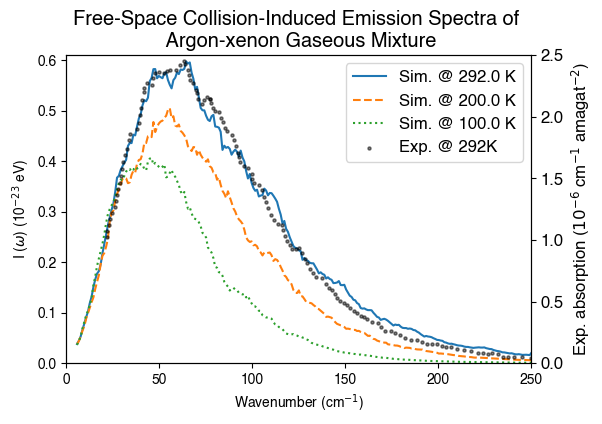

In [4]:
## from copy import deepcopy

fig,ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 12})

# plotting the experimental dataset
tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black', 
    label = 'Exp. @ 292K' if i == 0 else None
)
tax.set_ylabel(r'Exp. absorption ($10^{-6}$ cm$^{-1}$ amagat$^{-2}$)')
tax.set_ylim(-0.00,2.5)

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_512_DICT.items()):

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        del freefield_result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    
    rad_profile *= 1e23 ##############################################################
    
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    f = f[o > 5]
    o = o[o > 5]
    ax.plot(o, f, label = "Sim. @ {} K".format(temp), linestyle = linestyle_list[i])

    if temp == '100.0':
        rad_profile100 = f
        omega_profile100 = o

ax.scatter([], [], s = 5, alpha = 0.5, c = 'black', label = 'Exp. @ 292K')     
ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax.set_xlim(0,250)
ax.set_ylim(0.0, 0.61)
ax.set_ylabel(r"I ($\omega$) (10$^{-23}$ eV)")
ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")

ax.set_title("Free-Space Collision-Induced Emission Spectra of \n Argon-xenon Gaseous Mixture")

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

In [ ]:
CAVITYFIELD_RESULT_256b_DICT

In [ ]:
for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_256b_DICT.items()):
    print(temp)

    directory_dict = categorizing_pickle(cavityfield_result_path, '')
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        field = result_dict['field']
        
        print(j, np.sum(field.history['energy'][-1]))

In [ ]:
spectra_utils = importlib.reload(spectra_utils)

In [ ]:
CAVITYFIELD_RESULT_512z_DICT

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


512 Lxy2e1 (18.280773991495142+0j) 1.5775873615945948
256 Lxy2e1 (12.7674147848023+0j) 1.621638301291197


10578

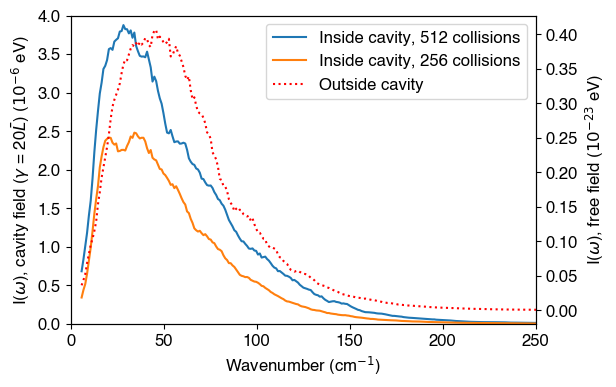

In [18]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768z_DICT,
    '512':CAVITYFIELD_RESULT_512z_DICT, 
    '256':CAVITYFIELD_RESULT_256z_DICT, 
}
limit = {'256':40, '512':20, '768':15}
colors = ['r', 'b']

fig,ax = plt.subplots(1, figsize = (6,4))
max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    cavityfield_result_path = result_dict['Lxy2e1']
        
    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile = []
    rad_profile_ = [] # for calculating the final temperature
    n_pickle = 0
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        # for calculating spectra
        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        #for calculating the field final temperature
        omega_profile, rad_profile2 = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'wavenumber':red.convert_wavenumber},
            mode = 'final'
        ) 
        rad_profile_.append(rad_profile2)

        n_pickle += 1
        if n_pickle > limit[no_collision]: break

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e3
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    f = f[o > 5]
    o = o[o > 5]
    ax.plot(o, f, label = 'Inside cavity, {} collisions'.format(no_collision))
    # to here for rad profile - end of copy

    ####
    if f_ == 0:
        max_r.update({i:np.max(rad_profile)})

    ### tabe here ###
        ax.set_xlim(0, 250)
        
        tax = ax.twinx()
        tax.plot(
            omega_profile100, rad_profile100 * (np.max(rad_profile)/ max_r[i]), 
            linestyle = linestyle_list[2], c = colors[f_]
        )
        tax.set_xlim(0, 250)
        #tax.set_ylim(0, 0.23)
    
        ax.set_ylabel(r"I($\omega$), cavity field ($\gamma$ = 20$\bar{L}$) ($10^{-6}$ eV)")
        tax.set_ylabel(r"I($\omega$), free field ($10^{-23}$ eV)")

    # print final temperature of the field
    temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
    print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))

ax.plot(
    [], [], label = "Outside cavity" , 
    linestyle = linestyle_list[2],color=colors[0]
)

ax.set_ylim(0, 4.0)

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')

ax.legend()

fig.savefig("figure/SI/cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

In [ ]:
np.mean(rad_profile_ * red.epsilon / red.boltzmann)

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


512 Lxy1e1 (103.40872428024066+0j) 4.877525613491713
512 Lxy2e1 (105.94225453331262+0j) 4.379015490344716


65450

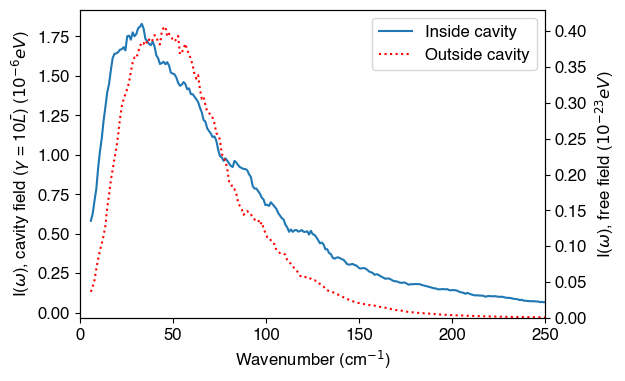

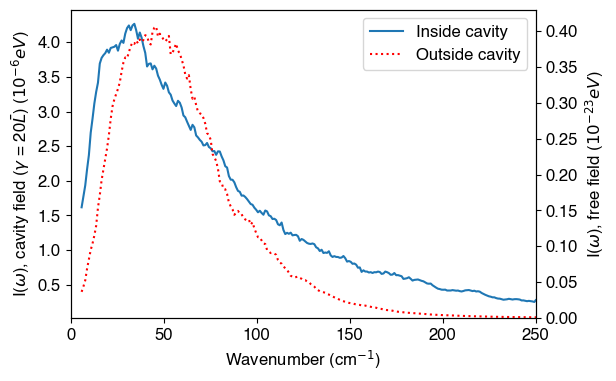

In [15]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768b_DICT,
    '512':CAVITYFIELD_RESULT_512b_DICT, 
    #'256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':20, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig1,ax1 = plt.subplots(1, figsize = (6,4))
fig2,ax2 = plt.subplots(1, figsize = (6,4))
fig = [fig1, fig2]
ax = [ax1, ax2]
max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)

            #for calculating the field final temperature
            omega_profile, rad_profile2 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'wavenumber':red.convert_wavenumber},
                mode = 'final'
            ) 
            rad_profile_.append(rad_profile2)
            
            del result_dict
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        f = f[o > 5]
        o = o[o > 5]
        ax[i].plot(o, f, label = 'Inside cavity'.format(no_collision))
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})
            
            #### tab here ###
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100, rad_profile100 * (np.max(rad_profile)/ max_r[i]), 
                linestyle = linestyle_list[2], c = colors[f_]
            )
            tax.set_xlim(0, 250)
            tax.set_ylim(0, 0.43)
        
            ax[i].set_ylabel(r"I($\omega$), cavity field ($\gamma$ = {}".format(ct_label[temp])+r"$\bar{L}$) ($10^{-6} eV$)")
            tax.set_ylabel(r"I($\omega$), free field ($10^{-23} eV$)")
            
        ax[i].set_xlim(0, 250)
        
        # print final temperature of the field
        temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
        print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))
        

        ax[i].plot(
            [], [], label = "Outside cavity" , 
            linestyle = linestyle_list[2],color=colors[0]
        )
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)
ax[0].set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

#ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()
ax[1].legend()

fig[0].savefig(fig_root + "boltzmann_cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

In [16]:
fig[1].savefig("figure/SI/boltzmann_cavity_spectrum_20L.jpeg",dpi = 600,bbox_inches = 'tight')

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(2,1, figsize = (6,8))

foo = {
    '256':CAVITYFIELD_RESULT_256z_DICT, 
    '512':CAVITYFIELD_RESULT_512z_DICT}

letters = ['a', 'b', 'c']

ct_dict = {}
limit = {'256':40, '512':20, '768':15}

for j,(no_collision, result_dict) in enumerate(foo.items()):
    food = {}
    for i, coup_str in enumerate(['Lxy2e1']):
        
        cavityfield_result_dict = result_dict[coup_str]
        ct = getall_colliding_time(cavityfield_result_dict, limit = limit[no_collision])
        ct = np.array(ct, dtype = np.float32)
    
        frame = np.arange(5.9999, 214.9999, 4.9999, dtype = np.float32)
        bin2 = ax[j].hist(ct, frame)
    
        food.update({coup_str : ct})
        
        del ct
        del cavityfield_result_dict
    
        ax[j].yaxis.set_major_formatter('{x:.0f}')
        
        ax[j].xaxis.set_major_locator(MultipleLocator(25))
        ax[j].set_xticks(list(ax[j].get_xticks()) + [6])
        ax[j].set_xlim(6,215)
    
        ax[j].set_ylim(0,30)
        ax[j].yaxis.set_major_locator(MultipleLocator(10))
        
        ax[j].set_ylim(0,175)
        ax[j].yaxis.set_major_locator(MultipleLocator(25))

        ax[j].annotate(
            '({})'.format(letters[j]), 
            xy = (0.5,0.9), xycoords = 'axes fraction',
            size = 'large', )
        
    ct_dict.update({no_collision: food})

ax[1].set_xlabel('Collision time (ps)')
#ax[1,2].set_xlabel('Colliding time (ps)')

ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')

#ax[0].annotate(r'cavity, 256 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[0].annotate(r'cavity, 512 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0].annotate('cavity, 256 atom pairs',xy = (0.3,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1].annotate('cavity, 512 atom pairs',xy = (0.3,0.8), xycoords = 'axes fraction', fontsize = 'large')

fig.savefig(fig_root + 'histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
gamma_coup_str_dict = {"Lxy1e1" : 10, "Lxy2e1" : 20}
for i, foo in ct_dict.items():
    for coup_str, ct in foo.items():
        #print(i, coup_str,len(ct[ct > 6]),  np.mean(ct[ct > 6]), len(ct[ct > 200]), len(ct))
        print("0K & {} & {} & {:.2f} $\pm$ {:.2f} & {:.2f} & {:.2f}".format(
            i ,gamma_coup_str_dict[coup_str],np.mean(ct[ct > 6]),np.std(ct[ct > 6]), len(ct[ct > 6]) * 100 / len(ct),  
            len(ct[ct > 200]) * 1000 / len(ct))
             )
        print("\\\\ \hline")

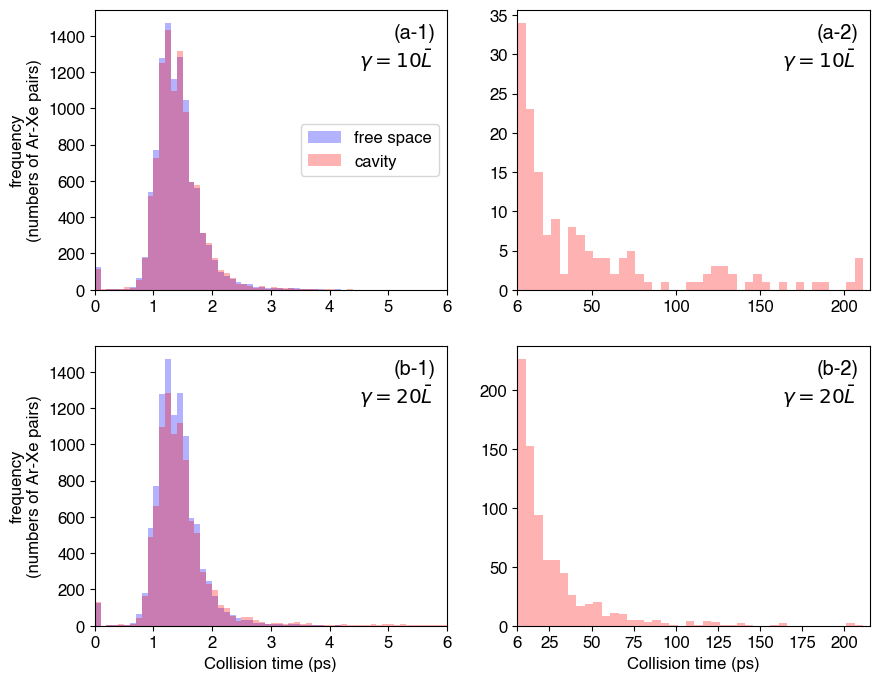

In [10]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(2,2, figsize = (10,8))

bin_dict = {}

ct0 = getall_colliding_time(FREEFIELD_RESULT_512_DICT['100.0'], limit = limit['512'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}
limit = {'256':40, '512':20, '768':15}
alpha = 0.3

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = limit['512'])

    ax[i,0].hist(ct0, np.arange(0,6 + 0.1, 0.1), alpha = alpha, color = 'blue',label = 'free space')
    bin1 = ax[i,0].hist(ct, np.arange(0,6 + 0.1, 0.1), color = 'red', alpha = alpha,label = 'cavity')
    bin2 = ax[i,1].hist(ct, np.arange(5.9999,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

    ct_dict2.update({coup_str : ct})
    
    del ct
    del cavityfield_result_dict
        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')

    if i == 0:  
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
    elif i == 1:
        ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [6])
    ax[i,1].set_xlim(6,215)
    ax[i,0].set_xlim(0,6)
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig(fig_root + 'histogram_boltzmann_512.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
# 256
for coup_str, ct in ct_dict2.items():
    print(coup_str,np.mean(ct[ct > 6]), len(ct[ct > 6])*100/len(ct),  len(ct[ct > 200])*1000/len(ct), len(ct))

In [ ]:
np.std(ct[ct > 6])

In [ ]:
# 512
for coup_str, ct in ct_dict2.items():
    print("100K & 512 & {} &  {:.2f} $\pm$ {:.2f} & {:.2f} & {:.2f}".format(
            gamma_coup_str_dict[coup_str],np.mean(ct[ct > 6]),np.std(ct[ct > 6]),len(ct[ct > 6]) * 100 / len(ct),  
            len(ct[ct > 200]) * 1000 / len(ct))
             )
    print("\\\\ \hline")

In [ ]:
from calculator.function import LJ_potential
def get_total_energy_loss(rd):
    atoms = rd['atoms']
    field = rd['field']
    
    N_pairs = int(len(atoms.r)/2)
    
    r_ar = np.array(atoms.trajectory['r'])[:,0]
    r_xe = np.array(atoms.trajectory['r'])[:,1]
    
    v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
    v_xe = np.array(atoms.trajectory['r_dot'])[:,1]
    
    t = red.convert_time(np.array(atoms.trajectory['t']))
    
    k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
        + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
    k = red.convert_energy(k,'ev') * 1e3
    
    d_arxe = r_ar - r_xe
    d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
    v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
    v = red.convert_energy(v,'ev') * 1e3
    
    hem = red.convert_energy(
        np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
    
    H = k + v + hem
    
    return red.convert_energy(abs(H[0] - H[-1]), 'ev')

In [ ]:
foo = {
    '256':CAVITYFIELD_RESULT_256b_DICT, 
    '512':CAVITYFIELD_RESULT_512b_DICT}


for j,(no_collision, result_dict) in enumerate(foo.items()):
    food = {}
    for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
        
        cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
        directory_dict = categorizing_pickle(cavityfield_result_dict, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
                
            print(coup_str, no_collision, get_total_energy_loss(result_dict))

# Repeating calculation for SI

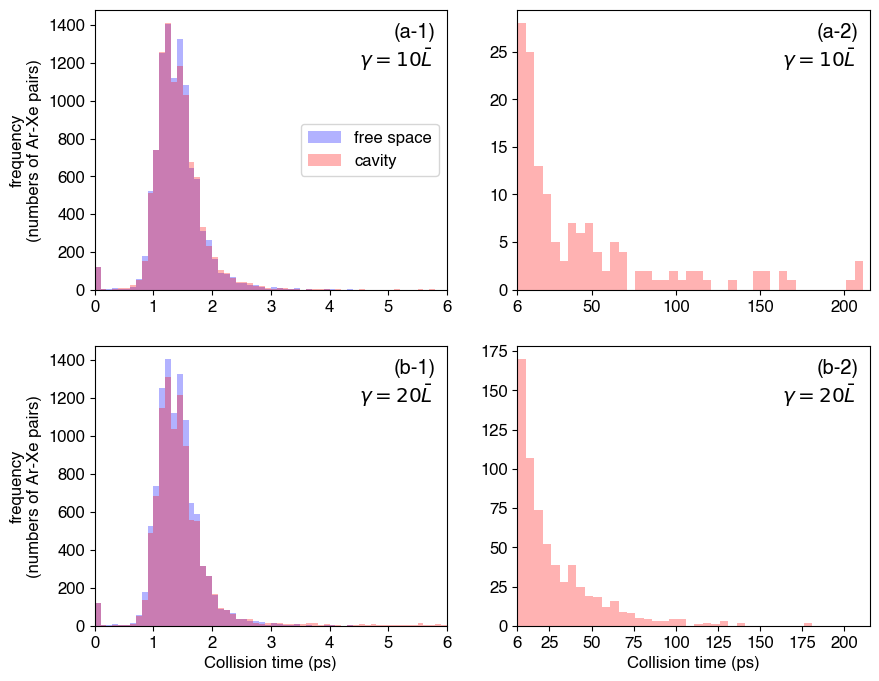

In [13]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(2,2, figsize = (10,8))

bin_dict = {}

ct0 = getall_colliding_time(FREEFIELD_RESULT_256_DICT['100.0'], limit = limit['256'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}
limit = {'256':40, '512':20, '768':15}
alpha = 0.3

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_256b_DICT[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = limit['256'])

    ax[i,0].hist(ct0, np.arange(0,6 + 0.1, 0.1), alpha = alpha, color = 'blue',label = 'free space')
    bin1 = ax[i,0].hist(ct, np.arange(0,6 + 0.1, 0.1), color = 'red', alpha = alpha,label = 'cavity')
    bin2 = ax[i,1].hist(ct, np.arange(5.9999,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

    ct_dict2.update({coup_str : ct})
    
    del ct
    del cavityfield_result_dict
        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')

    if i == 0:  
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
    elif i == 1:
        ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [6])
    ax[i,1].set_xlim(6,215)
    ax[i,0].set_xlim(0,6)
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.75,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig('figure/SI/histogram_boltzmann_256.jpeg',dpi=600, bbox_inches = 'tight')

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


256 Lxy1e1 (102.18476848720512+0j) 4.328483751153262
256 Lxy2e1 (104.21967446947288+0j) 4.595217198787685


8908

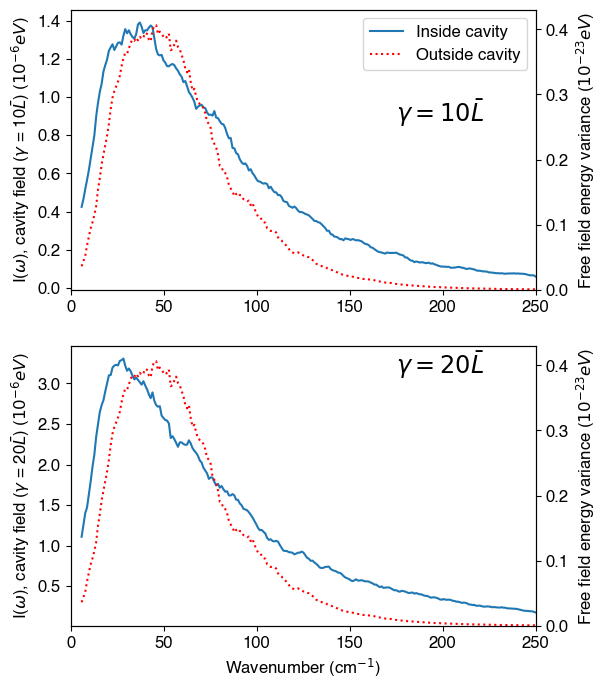

In [19]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768b_DICT,
    #'512':CAVITYFIELD_RESULT_512b_DICT, 
    '256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':20, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig,ax = plt.subplots(2, figsize = (6,8))
max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)

            #for calculating the field final temperature
            omega_profile, rad_profile2 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'wavenumber':red.convert_wavenumber},
                mode = 'final'
            ) 
            rad_profile_.append(rad_profile2)
            
            del result_dict
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        f = f[o > 5]
        o = o[o > 5]
        ax[i].plot(o, f, label = 'Inside cavity'.format(no_collision))
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})
            
            #### tab here ###
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100, rad_profile100 * (np.max(rad_profile)/ max_r[i]), 
                linestyle = linestyle_list[2], c = colors[f_]
            )
            tax.set_xlim(0, 250)
            tax.set_ylim(0, 0.43)
        
            ax[i].set_ylabel(r"I($\omega$), cavity field ($\gamma$ = {}".format(ct_label[temp])+r"$\bar{L}$) ($10^{-6} eV$)")
            tax.set_ylabel(r"Free field energy variance ($10^{-23} eV$)")
            
        ax[i].set_xlim(0, 250)
        
        # print final temperature of the field
        temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
        print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))
        

ax[0].plot(
    [], [], label = "Outside cavity" , 
    linestyle = linestyle_list[2],color=colors[0]
)
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)

ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()

fig.savefig("figure/SI/boltzmann_cavity_spectrum_256.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

In [ ]:
%reset -f